In [1]:
%load_ext autoreload
%autoreload 2

In [162]:
%run Model.ipynb

In [163]:
%run NimbroDataLoader.ipynb

In [164]:
%run NimbroSegmentDataLoader.ipynb

In [165]:
%%time
dataset1 = NimbroDataset('data/bigcuda5.informatik.uni-bonn.de:8686/blob/forceTest/',image_size=(HEIGHT,WIDTH))

CPU times: user 104 µs, sys: 2 µs, total: 106 µs
Wall time: 73.2 µs


In [166]:
%%time
dataset2 = NimbroDataset('data/bigcuda5.informatik.uni-bonn.de:8686/blob/forceTrain/',image_size=(HEIGHT,WIDTH))

CPU times: user 8.85 ms, sys: 9 µs, total: 8.86 ms
Wall time: 8.55 ms


In [167]:
%%time
dataset3 = NimbroDataset('data/bigcuda5.informatik.uni-bonn.de:8686/blob/dataset/',image_size=(HEIGHT,WIDTH))

CPU times: user 8.41 ms, sys: 4 ms, total: 12.4 ms
Wall time: 12.1 ms


In [168]:
dataset = ConcatDataset([dataset1,dataset2,dataset3])
len(dataset)

8868

In [433]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

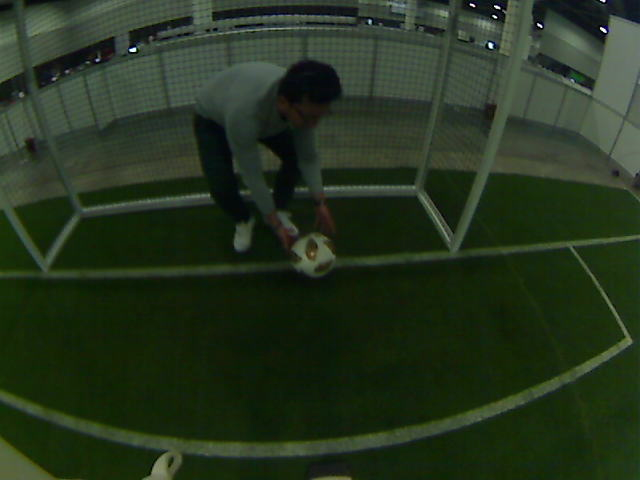

In [462]:
TF.to_pil_image(invTrans(dataset[1080][0]))

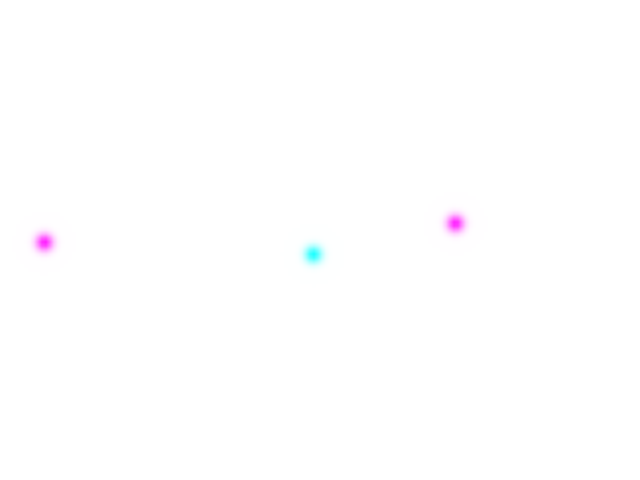

In [171]:
TF.resize(TF.to_pil_image(dataset[1080][1]),(480,640))

In [172]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [8100,len(dataset)-8100])

In [375]:
batch_size = 16
n_epochs = 10
lr = 0.001
nimbro_net = NimbroNet18()
optimizer = torch.optim.Adam(nimbro_net.parameters(), lr=lr, betas=(0.5, 0.999))


In [173]:
train_blob_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                               batch_size=batch_size, 
                               shuffle=True)
val_blob_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                               batch_size=batch_size, 
                               shuffle=False)

In [14]:
dataset_seg_1 = NimbroSegmentDataset('data/bigcuda5.informatik.uni-bonn.de:8686/segmentation/forceTrain/',(HEIGHT,WIDTH))
dataset_seg_2 = NimbroSegmentDataset('data/bigcuda5.informatik.uni-bonn.de:8686/segmentation/dataset/',(HEIGHT,WIDTH))

dataset_seg = ConcatDataset([dataset_seg_1,dataset_seg_2])
len(dataset_seg)

1192

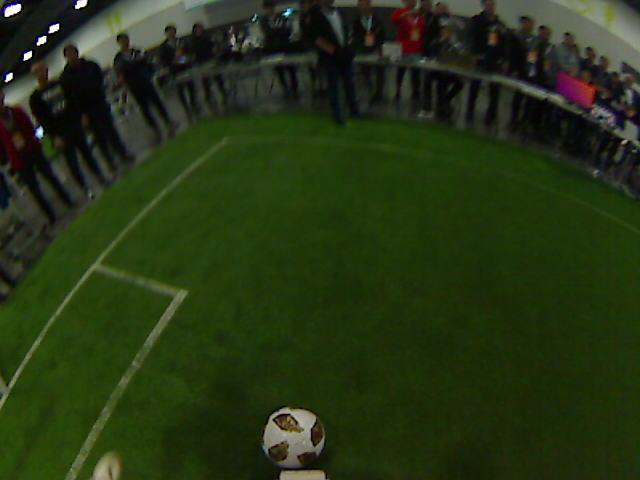

In [463]:
TF.to_pil_image(invTrans(dataset_seg_1[50][0]))

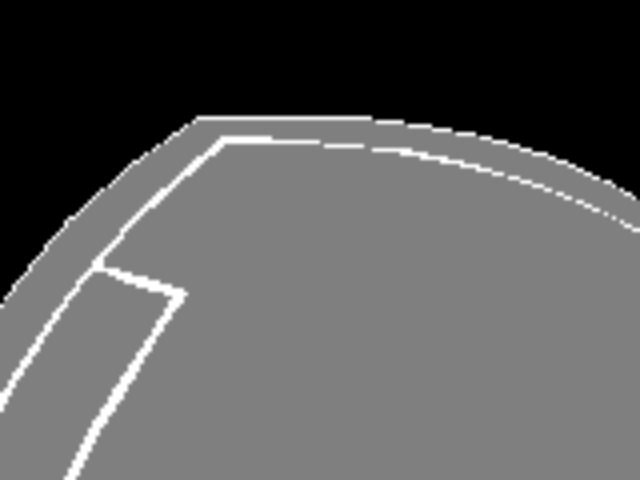

In [370]:
TF.resize(TF.to_pil_image(dataset_seg_1[50][1]/2),(480,640))

In [17]:
train_seg_dataset, test_seg_dataset = torch.utils.data.random_split(dataset_seg, [1050,len(dataset_seg)-1050])
train_seg_loader = torch.utils.data.DataLoader(dataset=train_seg_dataset, 
                               batch_size=batch_size, 
                               shuffle=True)
val_seg_loader = torch.utils.data.DataLoader(dataset=test_seg_dataset, 
                               batch_size=batch_size, 
                               shuffle=False)

In [378]:
nimbro_net.cuda()

NimbroNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tru

In [329]:
criterion_cross_ent = nn.CrossEntropyLoss()


def mse_loss_fn(y_hat,y):
    return ((y - y_hat)**2).sum()/y.shape[0]

def total_variation_loss(y):
    return torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :]))

In [20]:
import pdb

In [376]:
train_losses = []
val_losses = []

In [ ]:
nimbro_net.train()
var_loss_weight1 = 0.0000005
var_loss_weight2 = 0.0000002
# mse_loss_weight = 20
for epoch in range(200):
    for batch_id in range(500):
        images, target = next(iter(train_blob_loader))  

        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = images.cuda()
            target = target.cuda()

        optimizer.zero_grad()
        _,blob = nimbro_net(images)
        
        ttl_var_blob = total_variation_loss(blob)*var_loss_weight1
        mse_loss = mse_loss_fn(blob, target)
        blob_loss = ttl_var_blob + mse_loss
        blob_loss.backward()
        
        optimizer.step()
        
        images, target_seg = next(iter(train_seg_loader))  
        if torch.cuda.is_available():
            images = images.cuda()
            target_seg = target_seg.cuda()
            
        optimizer.zero_grad()
        seg,_ = nimbro_net(images)

        ttl_var_seg = total_variation_loss(seg[:,[0,1],:,:])*var_loss_weight2
        cross_loss = criterion_cross_ent(seg,target_seg.long())
        seg_loss = cross_loss + ttl_var_seg
        seg_loss.backward()
        
        train_losses.append((mse_loss,ttl_var_blob,cross_loss,ttl_var_seg))
        optimizer.step()
        
    print(f'Epoch:{epoch} Train MSE: {mse_loss.item():.3f}\t\tCross Entropy: {cross_loss.item():.3f}')
    print(f'\tVariance Loss Blobs:{ttl_var_blob:.2}\tVariance Loss Seg:{ttl_var_seg:.3}')

    
    nimbro_net.eval()
    with torch.no_grad():
        val_loss = 0
        seg_loss = 0
        tot_var_loss_blob = 0
        tot_var_loss_seg = 0

        for k,(images, target) in enumerate(val_blob_loader):
            #######################
            #  USE GPU FOR MODEL  #
            #######################
            if torch.cuda.is_available():
                images = images.cuda()
                target = target.cuda()

            # Forward pass only to get logits/output
            _,blob = nimbro_net(images)
            val_loss +=   (mse_loss_fn(blob,target).item()-val_loss)/(k+1)
            tot_var_loss_blob += (total_variation_loss(blob) - tot_var_loss_blob)/(k+1)

        for k,(images, target) in enumerate(val_seg_loader):
            #######################
            #  USE GPU FOR MODEL  #
            #######################
            if torch.cuda.is_available():
                images = images.cuda()
                target = target.cuda()

            # Forward pass only to get logits/output
            seg,_ = nimbro_net(images)
            seg_loss +=   (criterion_cross_ent(seg,target.long()).item()-seg_loss)/(k+1)
            tot_var_loss_seg += (total_variation_loss(seg[:,[0,1],:,:]) - tot_var_loss_seg)/(k+1)
        
    # Print Loss
    tot_var_loss_blob *= var_loss_weight1
    tot_var_loss_seg  *= var_loss_weight2
    print(f'\tValidation MSE Loss: {val_loss:.3f}\tCross Entropy: {seg_loss:.3f}')
    print(f'\tVariance Loss Blobs:{tot_var_loss_blob:.3}\tVariance Loss Seg:{tot_var_loss_seg:.2}\n--------------------------------------------------------------\n')
    val_losses.append((val_loss,tot_var_loss_blob,seg_loss,tot_var_loss_seg))
    nimbro_net.train()

In [439]:
train_losses[-1]

(tensor(7.3416, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0015, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(0.1138, device='cuda:0', grad_fn=<NllLoss2DBackward>),
 tensor(0.0284, device='cuda:0', grad_fn=<MulBackward0>))

In [440]:
val_losses[-1]

(14.877450287342073,
 tensor(0.0015, device='cuda:0'),
 0.11828003409836027,
 tensor(0.0281, device='cuda:0'))

In [427]:
len(train_losses)

45027

In [480]:
i=87
ds = test_seg_dataset

In [481]:
seg,blob = nimbro_net(ds[i][0].unsqueeze(0).cuda())

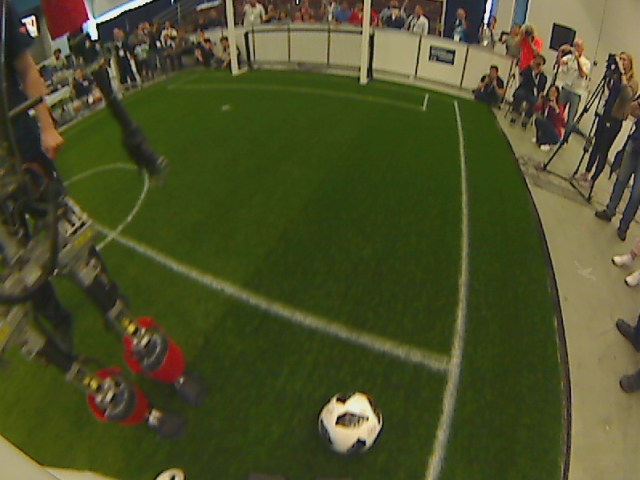

In [482]:
TF.to_pil_image(invTrans(ds[i][0]))

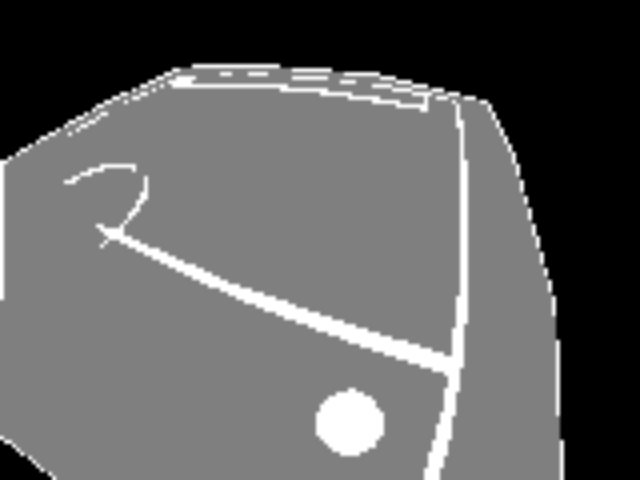

In [483]:
TF.resize(TF.to_pil_image(ds[i][1]/2),(480,640))

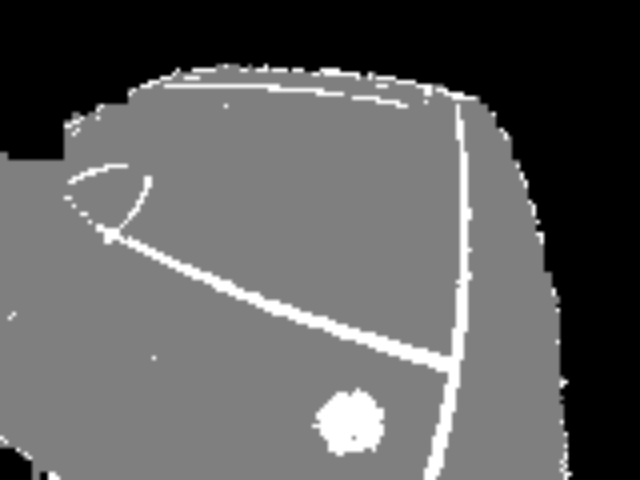

In [484]:
TF.resize(TF.to_pil_image(seg.cpu()[0].argmax(0)/2.0),(480,640))

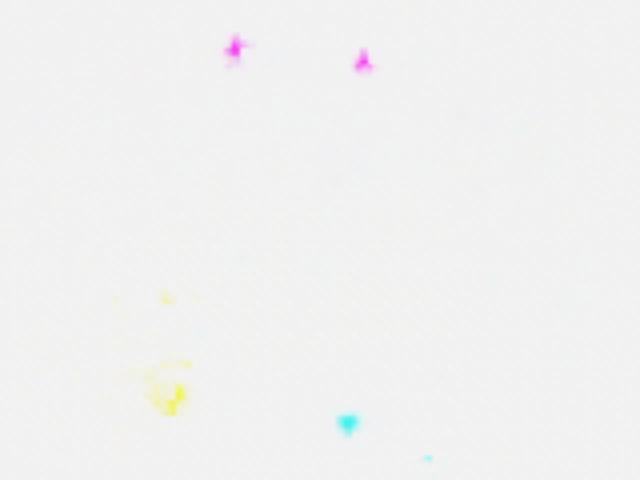

In [485]:
TF.resize(TF.to_pil_image(blob.cpu()[0]-0.05),(480,640))

In [325]:
((train_dataset[i][1][0] - blob[0].cpu())**2).sum()/blob.shape[0]

tensor(19.0604, grad_fn=<DivBackward0>)

In [318]:
blob[0]

tensor(0.9566, device='cuda:0', grad_fn=<MinBackward1>)

In [307]:
blob.max()

tensor(1.0545, device='cuda:0', grad_fn=<MaxBackward1>)

In [243]:

train_losses[-1]

(tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.0108, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(0.0258, device='cuda:0', grad_fn=<NllLoss2DBackward>),
 tensor(0.0684, device='cuda:0', grad_fn=<MulBackward0>))

In [245]:
val_losses[-1]

(0.0005545563138487826,
 tensor(0.0096, device='cuda:0'),
 0.169960414369901,
 tensor(0.0830, device='cuda:0'))

In [158]:
images, target = next(iter(train_blob_loader))  


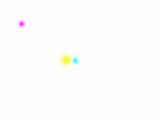

In [159]:
TF.to_pil_image(target[0])

In [161]:
target[0]

tensor([[[2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         ...,
         [2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.]],

        [[2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         ...,
         [2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.]],

        [[2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         ...,
         [2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.]]])

In [146]:
b = blob.cpu().detach().numpy()

In [148]:
np.unravel_index(b[0,0].argmax(),b.shape)

(0, 0, 73, 159)

In [149]:
np.unravel_index(b[0,0].argmin(),b.shape)

(0, 0, 33, 9)

In [100]:
2553%120

33

In [101]:
2553/120

21.275

In [ ]:
blob.cpu()[0,0]

In [97]:
blob.cpu()[0,0].max()

tensor(2.1388, grad_fn=<MaxBackward1>)

In [95]:
blob.cpu()[0,0].argmax()

tensor(2553)

In [102]:
blob.shape

torch.Size([1, 3, 120, 160])

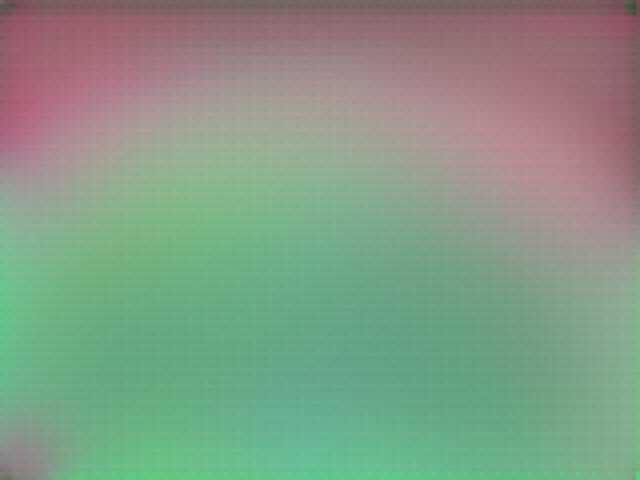

In [77]:
TF.resize(TF.to_pil_image(nimbro_net.loc_dep_bias.cpu()[0]*10),(480,640))

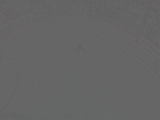

In [49]:
TF.to_pil_image(blob.cpu()[0]/5)

In [ ]:
dd

In [ ]:
TF.to_pil_image(train_dataset[445][0])

In [ ]:
train_dataset[445][1].shape

In [ ]:
8000*(120*160*3*4)/1000000

In [ ]:
with torch.no_grad():

    for k,(images, target) in enumerate(val_seg_loader):
            #######################
            #  USE GPU FOR MODEL  #
            #######################
            if torch.cuda.is_available():
                images = images
                target = target

            # Forward pass only to get logits/output
            seg,_ = nimbro_net(images)
            print(k)
            seg_loss +=   (criterion_cross_ent(seg,target.long()).item()-seg_loss)/(k+1)


In [ ]:
nimbro_net.cuda()

In [ ]:
del seg

In [ ]:
del blob

In [ ]:
torch.cuda.empty_cache()

In [ ]:
del target

In [ ]:
del images

In [ ]:
torch.cuda.memory_allocated()

In [ ]:
del seg_loss

In [ ]:
del val_loss

In [ ]:
del mse_loss

In [ ]:
del total_variation_loss

In [ ]:
del total_loss

In [ ]:
locals()